In [2]:
!pip install -q "tensorflow>=2.12,<2.24" optuna>=3.6.0 scikit-learn pandas matplotlib tqdm pycaret[full]==3.3.2 darts==0.30.0 lightgbm xgboost catboost
!pip install -q optuna==3.6.0 darts==0.30.0 pycaret==3.3.2 --upgrade


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.1.4 which is incompatible.
omegaconf 2.3.0 requires antlr4-python3-runtime==4.9.*, but you have antlr4-python3-runtime 4.11.1 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 2.1.4 which is incompatible.
arviz 0.22.0 requires matplotlib>=3.8, but you have matplotlib 3.7.5 which is incompatible.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you hav

In [1]:
import os, time, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("TensorFlow:", tf.__version__)
print("Optuna:", optuna.__version__)


TensorFlow: 2.19.0
Optuna: 3.6.0


In [10]:
# Load and prepare target safely

import pandas as pd
import numpy as np

CSV_PATH = "household_data_15min_clean.csv"  # Path to your cleaned dataset

# Load dataset
df = pd.read_csv(CSV_PATH, parse_dates=True)

# Detect and set timestamp column
time_cols = [c for c in df.columns if 'timestamp' in c.lower() or 'date' in c.lower() or 'time' in c.lower()]
if 'utc_timestamp' in df.columns:
    df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
    df = df.set_index('utc_timestamp').sort_index()
elif time_cols:
    df[time_cols[0]] = pd.to_datetime(df[time_cols[0]])
    df = df.set_index(time_cols[0]).sort_index()
else:
    raise ValueError("No timestamp column found in dataset.")

# Detect all available household prefixes
prefixes = sorted({c.rsplit('_', 2)[0] for c in df.columns if c.startswith("DE_KN_residential")})
print("Available households:", prefixes)

# Find households with nonzero net balance activity
activity_stats = []
for pref in prefixes:
    col_import = f"{pref}_grid_import"
    col_export = f"{pref}_grid_export"
    if col_import in df.columns and col_export in df.columns:
        net = df[col_import].fillna(0) - df[col_export].fillna(0)
        nonzero_frac = (net != 0).mean()
        activity_stats.append((pref, nonzero_frac))

if not activity_stats:
    raise ValueError("No residential household columns found in dataset.")

# Pick household with the highest nonzero fraction
HOUSE_PREFIX, best_frac = max(activity_stats, key=lambda x: x[1])
print(f"Using household: {HOUSE_PREFIX} (nonzero fraction = {best_frac:.4f})")

# Build final column names
col_import = f"{HOUSE_PREFIX}_grid_import"
col_export = f"{HOUSE_PREFIX}_grid_export"
col_pv = f"{HOUSE_PREFIX}_pv"

# Check and warn if columns are missing
for c in [col_import, col_export, col_pv]:
    if c not in df.columns:
        print("WARNING: Missing column:", c)

# Create net_balance
df[col_import] = df.get(col_import, 0.0)
df[col_export] = df.get(col_export, 0.0)
df[col_pv] = df.get(col_pv, 0.0)
df['net_balance'] = df[col_import].fillna(0) - df[col_export].fillna(0)

# Fill and interpolate numeric columns
df_num = df.select_dtypes(include=[np.number]).interpolate(limit_direction='both').ffill().bfill()

# Auto-trim the long zero region in net_balance
nonzero_idx = np.flatnonzero(df_num['net_balance'].values != 0)

if len(nonzero_idx) > 0:
    first_nonzero = nonzero_idx[0]
    print(f"Trimming dataset: skipping first {first_nonzero} zero-only rows.")
    df_num = df_num.iloc[first_nonzero:].copy()
else:
    print("WARNING: net_balance is entirely zero. Model may not train meaningfully.")

print("\nDataset Summary:")
print("Rows:", len(df_num))
print("Columns:", len(df_num.columns))
print("Nonzero fraction in net_balance:", (df_num['net_balance'] != 0).mean())

display(df_num[[col_import, col_export, col_pv, 'net_balance']].head(10))


Available households: ['DE_KN', 'DE_KN_residential2', 'DE_KN_residential3', 'DE_KN_residential4', 'DE_KN_residential5', 'DE_KN_residential6']
Using household: DE_KN_residential4 (nonzero fraction = 0.5294)
Trimming dataset: skipping first 29084 zero-only rows.

Dataset Summary:
Rows: 124726
Columns: 21
Nonzero fraction in net_balance: 0.6528951461603836


,DE_KN_residential4_grid_import,DE_KN_residential4_grid_export,DE_KN_residential4_pv,net_balance
utc_timestamp,,,,
2015-10-10 16:45:00+00:00,0.000004,0.0,0.0,0.000004
2015-10-10 17:00:00+00:00,0.000007,0.0,0.0,0.000007
2015-10-10 17:15:00+00:00,0.000014,0.0,0.0,0.000014
2015-10-10 17:30:00+00:00,0.000031,0.0,0.0,0.000031
2015-10-10 17:45:00+00:00,0.000084,0.0,0.0,0.000084
2015-10-10 18:00:00+00:00,0.000127,0.0,0.0,0.000127
2015-10-10 18:15:00+00:00,0.000143,0.0,0.0,0.000143
2015-10-10 18:30:00+00:00,0.000150,0.0,0.0,0.000150
2015-10-10 18:45:00+00:00,0.000158,0.0,0.0,0.000158


In [11]:
# Filter out long zero stretches
print("Original rows:", len(df_num))
active_df = df_num[df_num['net_balance'].abs() > 1e-6].copy()
print(f"Filtered dataset: {len(active_df)} rows retained ({100 * len(active_df)/len(df_num):.1f}%)")

# Replace df_num with filtered version for next steps
df_num = active_df


Original rows: 124726
Filtered dataset: 81433 rows retained (65.3%)


In [13]:
# Feature engineering and creating three feature variants
df_feat = df_num.copy()

# Basic time features
df_feat['hour'] = df_feat.index.hour
df_feat['dow'] = df_feat.index.dayofweek
df_feat['hour_sin'] = np.sin(2*np.pi * df_feat['hour']/24)
df_feat['hour_cos'] = np.cos(2*np.pi * df_feat['hour']/24)

# rolling features (conv bias)
for w in [3,6,12]:
    df_feat[f"pv_ma_{w}"] = df_feat[col_pv].rolling(w, min_periods=1).mean().fillna(0)
    df_feat[f"pv_std_{w}"] = df_feat[col_pv].rolling(w, min_periods=1).std().fillna(0)

# Select columns for each variant
rnn_cols = [col_import, col_export, col_pv, 'net_balance']  # minimal
conv_cols = [col_import, col_export, col_pv, 'pv_ma_3', 'pv_ma_6', 'pv_std_3', 'pv_std_6', 'net_balance']
trans_cols = [col_import, col_export, col_pv, 'hour_sin', 'hour_cos', 'net_balance']

rnn_df = df_feat[rnn_cols].copy()
conv_df = df_feat[conv_cols].copy()
trans_df = df_feat[trans_cols].copy()

print("rnn_df cols:", rnn_df.columns.tolist())
print("conv_df cols:", conv_df.columns.tolist())
print("trans_df cols:", trans_df.columns.tolist())


rnn_df cols: ['DE_KN_residential4_grid_import', 'DE_KN_residential4_grid_export', 'DE_KN_residential4_pv', 'net_balance']
conv_df cols: ['DE_KN_residential4_grid_import', 'DE_KN_residential4_grid_export', 'DE_KN_residential4_pv', 'pv_ma_3', 'pv_ma_6', 'pv_std_3', 'pv_std_6', 'net_balance']
trans_df cols: ['DE_KN_residential4_grid_import', 'DE_KN_residential4_grid_export', 'DE_KN_residential4_pv', 'hour_sin', 'hour_cos', 'net_balance']


In [33]:
# Windowing (70% train, 15% val, 15% test)
n_total = len(df_feat)
train_end = int(n_total * 0.70)
val_end = int(n_total * 0.85)

train_df = df_feat.iloc[:train_end]
val_df   = df_feat.iloc[train_end:val_end]
test_df  = df_feat.iloc[val_end:]

print("Rows split -> train:", len(train_df), "val:", len(val_df), "test:", len(test_df))
def create_windows_from_df(df_local, input_len=96, horizon=1, stride=1, target_col='net_balance'):
    arr = df_local.values.astype(np.float32)
    cols = df_local.columns.tolist()
    tidx = cols.index(target_col)
    N = arr.shape[0]
    Xs, ys = [], []
    max_start = N - input_len - horizon + 1
    if max_start <= 0:
        return np.empty((0,input_len,arr.shape[1]), dtype=np.float32), np.empty((0,), dtype=np.float32), cols
    for s in range(0, max_start, stride):
        Xs.append(arr[s:s+input_len, :])
        ys.append(arr[s+input_len+horizon-1, tidx])
    return np.array(Xs), np.array(ys), cols

# create windows separately for each split and each variant
Xr_tr, yr_tr, cols_r = create_windows_from_df(train_df[rnn_cols],  input_len=INPUT_LEN, stride=STRIDE)
Xr_val, yr_val, _     = create_windows_from_df(val_df[rnn_cols],    input_len=INPUT_LEN, stride=STRIDE)
Xr_te, yr_te, _       = create_windows_from_df(test_df[rnn_cols],   input_len=INPUT_LEN, stride=STRIDE)

Xc_tr, yc_tr, cols_c = create_windows_from_df(train_df[conv_cols],  input_len=INPUT_LEN, stride=STRIDE)
Xc_val, yc_val, _     = create_windows_from_df(val_df[conv_cols],    input_len=INPUT_LEN, stride=STRIDE)
Xc_te, yc_te, _       = create_windows_from_df(test_df[conv_cols],   input_len=INPUT_LEN, stride=STRIDE)

Xt_tr, yt_tr, cols_t = create_windows_from_df(train_df[trans_cols], input_len=INPUT_LEN, stride=STRIDE)
Xt_val, yt_val, _     = create_windows_from_df(val_df[trans_cols],   input_len=INPUT_LEN, stride=STRIDE)
Xt_te, yt_te, _       = create_windows_from_df(test_df[trans_cols],  input_len=INPUT_LEN, stride=STRIDE)

print("RNN windows:", Xr_tr.shape, yr_tr.shape, "val:", Xr_val.shape, yr_val.shape, "test:", Xr_te.shape, yr_te.shape)
print("Conv windows:", Xc_tr.shape, yc_tr.shape, "val:", Xc_val.shape, yc_val.shape, "test:", Xc_te.shape, yc_te.shape)
print("Trans windows:", Xt_tr.shape, yt_tr.shape, "val:", Xt_val.shape, yt_val.shape, "test:", Xt_te.shape, yt_te.shape)


Rows split -> train: 57003 val: 12215 test: 12215
RNN windows: (14227, 96, 4) (14227,) val: (3030, 96, 4) (3030,) test: (3030, 96, 4) (3030,)
Conv windows: (14227, 96, 8) (14227,) val: (3030, 96, 8) (3030,) test: (3030, 96, 8) (3030,)
Trans windows: (14227, 96, 6) (14227,) val: (3030, 96, 6) (3030,) test: (3030, 96, 6) (3030,)


In [34]:
# Time-based split
def time_split(X, y, train_frac=0.7, val_frac=0.15):
    n = len(X)
    train_end = int(n*train_frac)
    val_end = int(n*(train_frac+val_frac))
    return X[:train_end], y[:train_end], X[train_end:val_end], y[train_end:val_end], X[val_end:], y[val_end:]

Xr_tr, yr_tr, Xr_val, yr_val, Xr_te, yr_te = time_split(Xr, yr)
Xc_tr, yc_tr, Xc_val, yc_val, Xc_te, yc_te = time_split(Xc, yc)
Xt_tr, yt_tr, Xt_val, yt_val, Xt_te, yt_te = time_split(Xt, yt)

print("RNN train/val/test sizes:", Xr_tr.shape[0], Xr_val.shape[0], Xr_te.shape[0])


RNN train/val/test sizes: 14234 3050 3051


In [35]:
# Scaling per-variant
from sklearn.preprocessing import StandardScaler
def scale_variant(X_train, X_val, X_test):
    n,t,f = X_train.shape
    scaler = StandardScaler()
    scaler.fit(X_train.reshape(-1, f))
    def transform(X):
        n,t,f = X.shape
        X2 = X.reshape(-1, f)
        X2 = scaler.transform(X2)
        return X2.reshape(n,t,f)
    return transform(X_train), transform(X_val), transform(X_test), scaler

Xr_tr_s, Xr_val_s, Xr_te_s, scaler_r = scale_variant(Xr_tr, Xr_val, Xr_te)
Xc_tr_s, Xc_val_s, Xc_te_s, scaler_c = scale_variant(Xc_tr, Xc_val, Xc_te)
Xt_tr_s, Xt_val_s, Xt_te_s, scaler_t = scale_variant(Xt_tr, Xt_val, Xt_te)

print("Scaled shapes:", Xr_tr_s.shape, Xc_tr_s.shape, Xt_tr_s.shape)


Scaled shapes: (14234, 96, 4) (14234, 96, 8) (14234, 96, 6)


In [36]:
# Model Builder Factories
from tensorflow import keras
from tensorflow.keras import layers

#  ---------- LSTM MODEL ----------
def build_lstm_model(input_shape, n_units=64, n_layers=1, dropout=0.1, lr=1e-3):
    inp = keras.Input(shape=input_shape)
    x = inp
    for i in range(n_layers):
        return_seq = (i < n_layers - 1)
        x = layers.LSTM(n_units, return_sequences=return_seq)(x)
        if dropout > 0:
            x = layers.Dropout(dropout)(x)

    # Single regression output
    out = layers.Dense(1)(x)

    model = keras.Model(inp, out)

    # Added 'mae' metric for proper evaluation
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='mae',
        metrics=['mae']
    )
    return model


# ---------- CONV1D MODEL ----------
def build_conv1d_model(input_shape, n_filters=64, kernel_size=3, n_layers=2, pool_size=2, lr=1e-3):
    inp = keras.Input(shape=input_shape)
    x = inp
    for i in range(n_layers):
        x = layers.Conv1D(
            filters=n_filters,
            kernel_size=kernel_size,
            padding='causal',
            activation='relu'
        )(x)
        x = layers.MaxPooling1D(pool_size=pool_size)(x)
        x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1)(x)

    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='mae',
        metrics=['mae']
    )
    return model


# ---------- TRANSFORMER HELPERS ----------
def transformer_block(x, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head self-attention
    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=head_size,
        dropout=dropout
    )(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward network
    ff = layers.Dense(ff_dim, activation='relu')(x)
    ff = layers.Dense(x.shape[-1])(ff)
    x = layers.Add()([x, ff])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x


# ---------- TRANSFORMER MODEL ----------
def build_transformer_model(input_shape, head_size=32, num_heads=4, ff_dim=64, n_blocks=2, lr=1e-3):
    inp = keras.Input(shape=input_shape)
    x = inp

    for _ in range(n_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(1)(x)

    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='mae',
        metrics=['mae']  #added for Optuna evaluation
    )
    return model


In [37]:
# Optuna objectives (corrected)
import math
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

def objective_lstm(trial):
    # hyperparams
    n_units = trial.suggest_categorical("n_units", [32, 64, 128])
    n_layers = trial.suggest_int("n_layers", 1, 2)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch = trial.suggest_categorical("batch", [32, 64])

    # build model
    model = build_lstm_model(
        input_shape=(INPUT_LEN, Xr_tr_s.shape[2]),
        n_units=n_units,
        n_layers=n_layers,
        dropout=dropout,
        lr=lr
    )

    # early stopping
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # train model
    model.fit(
        Xr_tr_s, yr_tr,
        validation_data=(Xr_val_s, yr_val),
        epochs=30,
        batch_size=batch,
        callbacks=[es],
        verbose=0
    )

    # compute MAE manually
    y_pred = model.predict(Xr_val_s, verbose=0)
    val_mae = mean_absolute_error(yr_val, y_pred)

    trial.set_user_attr("model", model)
    return val_mae


def objective_conv(trial):
    n_filters = trial.suggest_categorical("n_filters", [32, 64, 128])
    kernel_size = trial.suggest_categorical("kernel_size", [3, 5, 7])
    n_layers = trial.suggest_int("n_layers", 1, 3)
    pool = trial.suggest_categorical("pool", [2, 3])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch = trial.suggest_categorical("batch", [32, 64])

    model = build_conv1d_model(
        input_shape=(INPUT_LEN, Xc_tr_s.shape[2]),
        n_filters=n_filters,
        kernel_size=kernel_size,
        n_layers=n_layers,
        pool_size=pool,
        lr=lr
    )

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(
        Xc_tr_s, yc_tr,
        validation_data=(Xc_val_s, yc_val),
        epochs=30,
        batch_size=batch,
        callbacks=[es],
        verbose=0
    )

    # compute MAE manually
    y_pred = model.predict(Xc_val_s, verbose=0)
    val_mae = mean_absolute_error(yc_val, y_pred)

    trial.set_user_attr("model", model)
    return val_mae


def objective_trans(trial):
    head_size = trial.suggest_categorical("head_size", [16, 32, 64])
    num_heads = trial.suggest_categorical("num_heads", [2, 4])
    ff_dim = trial.suggest_categorical("ff_dim", [32, 64, 128])
    n_blocks = trial.suggest_int("n_blocks", 1, 3)
    lr = trial.suggest_float("lr", 1e-4, 1e-3, log=True)
    batch = trial.suggest_categorical("batch", [16, 32])

    model = build_transformer_model(
        input_shape=(INPUT_LEN, Xt_tr_s.shape[2]),
        head_size=head_size,
        num_heads=num_heads,
        ff_dim=ff_dim,
        n_blocks=n_blocks,
        lr=lr
    )

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(
        Xt_tr_s, yt_tr,
        validation_data=(Xt_val_s, yt_val),
        epochs=30,
        batch_size=batch,
        callbacks=[es],
        verbose=0
    )

    # compute MAE manually
    y_pred = model.predict(Xt_val_s, verbose=0)
    val_mae = mean_absolute_error(yt_val, y_pred)

    trial.set_user_attr("model", model)
    return val_mae


In [38]:
# Run optuna studies
n_trials = 15  # can be 30-50 as well

study_lstm = optuna.create_study(direction="minimize")
study_lstm.optimize(objective_lstm, n_trials=n_trials)
best_lstm = study_lstm.best_trial.user_attrs['model']
print("Best LSTM trial value (val MAE):", study_lstm.best_value)

study_conv = optuna.create_study(direction="minimize")
study_conv.optimize(objective_conv, n_trials=n_trials)
best_conv = study_conv.best_trial.user_attrs['model']
print("Best Conv trial value (val MAE):", study_conv.best_value)

study_trans = optuna.create_study(direction="minimize")
study_trans.optimize(objective_trans, n_trials=n_trials)
best_trans = study_trans.best_trial.user_attrs['model']
print("Best Trans trial value (val MAE):", study_trans.best_value)


[I 2025-10-12 04:10:36,344] A new study created in memory with name: no-name-4c939347-9395-4aaa-8d7d-01c444d08942
[I 2025-10-12 04:11:01,782] Trial 0 finished with value: 0.0018885991303250194 and parameters: {'n_units': 32, 'n_layers': 2, 'dropout': 0.1947080500456155, 'lr': 0.0017329102248817801, 'batch': 64}. Best is trial 0 with value: 0.0018885991303250194.
[I 2025-10-12 04:11:42,320] Trial 1 finished with value: 0.0013523136731237173 and parameters: {'n_units': 32, 'n_layers': 2, 'dropout': 0.2736212319206355, 'lr': 0.0015619186880091976, 'batch': 64}. Best is trial 1 with value: 0.0013523136731237173.
[I 2025-10-12 04:12:05,487] Trial 2 finished with value: 0.0025360677391290665 and parameters: {'n_units': 128, 'n_layers': 2, 'dropout': 0.3877557608780397, 'lr': 0.0027666663052400803, 'batch': 64}. Best is trial 1 with value: 0.0013523136731237173.
[I 2025-10-12 04:12:45,370] Trial 3 finished with value: 0.003389783203601837 and parameters: {'n_units': 32, 'n_layers': 2, 'dropou

Best LSTM trial value (val MAE): 0.00026602589059621096


[I 2025-10-12 04:20:58,849] Trial 0 finished with value: 0.016915082931518555 and parameters: {'n_filters': 32, 'kernel_size': 7, 'n_layers': 3, 'pool': 2, 'lr': 0.003976023551228044, 'batch': 32}. Best is trial 0 with value: 0.016915082931518555.
[I 2025-10-12 04:21:23,829] Trial 1 finished with value: 0.025960775092244148 and parameters: {'n_filters': 32, 'kernel_size': 7, 'n_layers': 2, 'pool': 3, 'lr': 0.0005832332960524889, 'batch': 32}. Best is trial 0 with value: 0.016915082931518555.
[I 2025-10-12 04:21:57,345] Trial 2 finished with value: 0.013169468380510807 and parameters: {'n_filters': 128, 'kernel_size': 3, 'n_layers': 2, 'pool': 2, 'lr': 0.008812230449303106, 'batch': 64}. Best is trial 2 with value: 0.013169468380510807.
[I 2025-10-12 04:22:22,990] Trial 3 finished with value: 0.007852783426642418 and parameters: {'n_filters': 128, 'kernel_size': 3, 'n_layers': 2, 'pool': 2, 'lr': 0.0008229233610093542, 'batch': 64}. Best is trial 3 with value: 0.007852783426642418.
[I 2

Best Conv trial value (val MAE): 0.0011673319386318326


[I 2025-10-12 04:27:31,026] Trial 0 finished with value: 0.002547494601458311 and parameters: {'head_size': 32, 'num_heads': 2, 'ff_dim': 128, 'n_blocks': 3, 'lr': 0.00013149057878363306, 'batch': 32}. Best is trial 0 with value: 0.002547494601458311.
[I 2025-10-12 04:28:11,463] Trial 1 finished with value: 0.0023642932064831257 and parameters: {'head_size': 32, 'num_heads': 2, 'ff_dim': 64, 'n_blocks': 2, 'lr': 0.00011635618331780281, 'batch': 32}. Best is trial 1 with value: 0.0023642932064831257.
[I 2025-10-12 04:29:08,564] Trial 2 finished with value: 0.0028247046284377575 and parameters: {'head_size': 64, 'num_heads': 2, 'ff_dim': 128, 'n_blocks': 2, 'lr': 0.00011347344000323769, 'batch': 16}. Best is trial 1 with value: 0.0023642932064831257.
[I 2025-10-12 04:30:23,681] Trial 3 finished with value: 0.004128041211515665 and parameters: {'head_size': 16, 'num_heads': 2, 'ff_dim': 128, 'n_blocks': 3, 'lr': 0.00020475608826184464, 'batch': 16}. Best is trial 1 with value: 0.002364293

Best Trans trial value (val MAE): 0.0013588154688477516


In [39]:
for pref in prefixes:
    col_import = f"{pref}_grid_import"
    col_export = f"{pref}_grid_export"
    if col_import in df.columns and col_export in df.columns:
        net = df[col_import].fillna(0) - df[col_export].fillna(0)
        nonzero_frac = (net != 0).mean()
        print(f"{pref:30s} -> nonzero fraction: {nonzero_frac:.4f}")


DE_KN_residential4             -> nonzero fraction: 0.5294


In [40]:
# check target variance
print("y train min/max:", yr_tr.min(), yr_tr.max())
print("y val min/max:", yr_val.min(), yr_val.max())
print("y train unique values:", np.unique(yr_tr))
print("y val unique values:", np.unique(yr_val))


y train min/max: -0.11773368 0.18684398
y val min/max: -0.15836895 0.052869458
y train unique values: [-0.11773368 -0.11770935 -0.11768515 ...  0.18660708  0.18676353
  0.18684398]
y val unique values: [-0.15836895 -0.15835908 -0.15835324 ...  0.05285648  0.0528624
  0.05286946]


In [41]:
# Evaluation and regression report

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (np.where(np.abs(y_true)<1e-6, 1e-6, y_true)))) * 100
    return {"mae":mae, "mse":mse, "rmse":rmse, "r2":r2, "mape_pct":mape}

def report_model(name, model, X_test, y_test):
    preds = model.predict(X_test).reshape(-1)
    metrics = regression_metrics(y_test, preds)
    params = model.count_params()
    # latency test
    t0 = time.time()
    for _ in range(10):
        _ = model.predict(X_test[:32], verbose=0)
    latency = (time.time() - t0) / 10
    print(f"\n--- {name} ---")
    print("MAE: {:.6f}, RMSE: {:.6f}, R2: {:.4f}, MAPE%: {:.3f}".format(metrics['mae'], metrics['rmse'], metrics['r2'], metrics['mape_pct']))
    print("Params:", params, "Avg inference time (s) per batch32:", latency)
    return {"model": name, **metrics, "params": params, "latency": latency, "preds": preds}

# Evaluate all three optimized models
res_lstm  = report_model("LSTM",  best_lstm,  Xr_te_s, yr_te)
res_conv  = report_model("Conv",  best_conv,  Xc_te_s, yc_te)
res_trans = report_model("Trans", best_trans, Xt_te_s, yt_te)

# Combine evaluation results
results_df = pd.DataFrame([
    {k:v for k,v in res.items() if k not in ['preds']}
    for res in [res_lstm, res_conv, res_trans]
])

# Add a 'name' column (needed for Pareto plotting)
results_df['name'] = results_df['model']

display(results_df)

# Identify the best performing model
best_model_row = results_df.loc[results_df['r2'].idxmax()]
print("\nBest Performing Model Summary:")
print(f"Model: {best_model_row['model']}")
print(f"MAE: {best_model_row['mae']:.6f}")
print(f"RMSE: {best_model_row['rmse']:.6f}")
print(f"R²: {best_model_row['r2']:.6f}")
print(f"MAPE: {best_model_row['mape_pct']:.3f}%")
print(f"Params: {best_model_row['params']}, Latency: {best_model_row['latency']:.6f}s")


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

--- LSTM ---
MAE: 0.000556, RMSE: 0.000628, R2: 0.9999, MAPE%: 5.366
Params: 68225 Avg inference time (s) per batch32: 0.052521276473999026
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

--- Conv ---
MAE: 0.001495, RMSE: 0.001698, R2: 0.9991, MAPE%: 2.918
Params: 265473 Avg inference time (s) per batch32: 0.054067468643188475
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

--- Trans ---
MAE: 0.003875, RMSE: 0.004831, R2: 0.9926, MAPE%: 16.862
Params: 2245 Avg inference time (s) per batch32: 0.05283546447753906


,model,mae,mse,rmse,r2,mape_pct,params,latency,name
0,LSTM,0.000556,3.946977e-07,0.000628,0.999875,5.365874,68225,0.052521,LSTM
1,Conv,0.001495,2.884721e-06,0.001698,0.999087,2.917985,265473,0.054067,Conv
2,Trans,0.003875,2.333804e-05,0.004831,0.992610,16.861804,2245,0.052835,Trans



Best Performing Model Summary:
Model: LSTM
MAE: 0.000556
RMSE: 0.000628
R²: 0.999875
MAPE: 5.366%
Params: 68225, Latency: 0.052521s


Pareto-optimal models (best trade-offs between accuracy and complexity):


,model,mae,mse,rmse,r2,mape_pct,params,latency,name,pareto
0,LSTM,0.000556,3.946977e-07,0.000628,0.999875,5.365874,68225,0.052521,LSTM,True
2,Trans,0.003875,2.333804e-05,0.004831,0.992610,16.861804,2245,0.052835,Trans,True


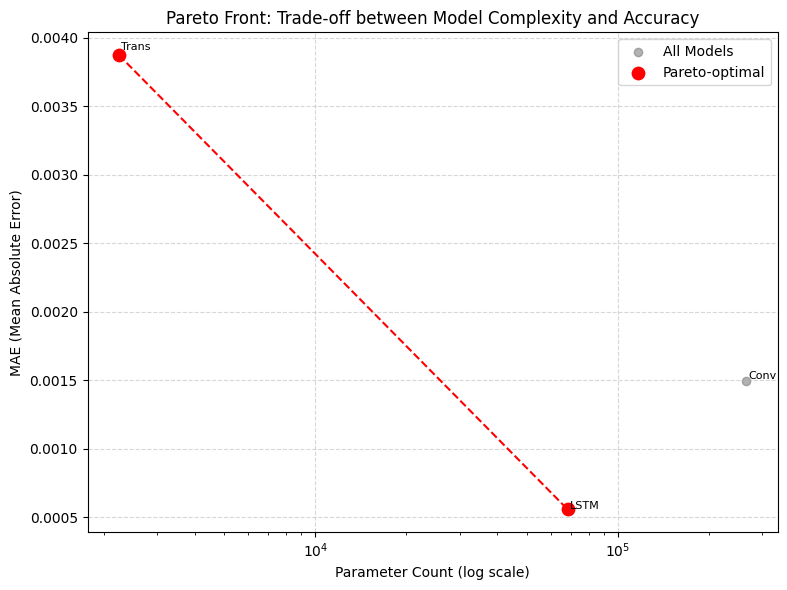


--------------------------------------------------------------------------------

Plotting Actual vs Predicted for best model: LSTM


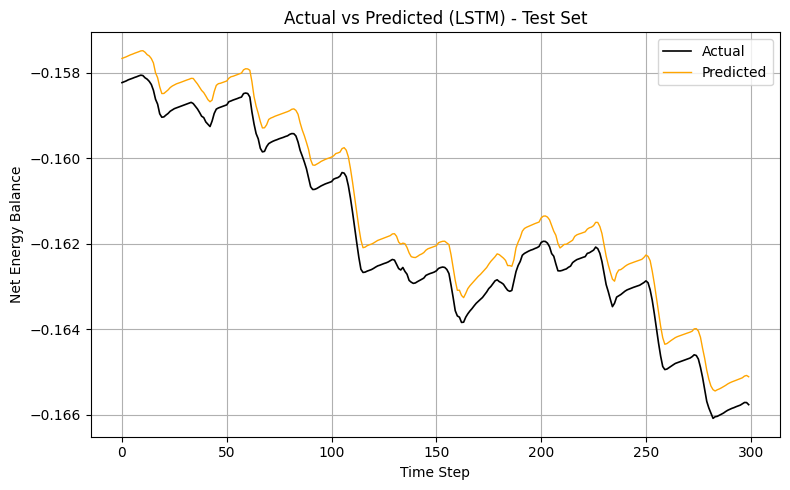

In [47]:
# Pareto front (MAE vs params)
df_plot = results_df.copy()

# Find Pareto-efficient ones (minimize both MAE and params)
points = df_plot[['params', 'mae']].values
is_efficient = np.ones(points.shape[0], dtype=bool)
for i, p in enumerate(points):
    is_efficient[i] = not np.any(
        (points[:, 0] <= p[0]) & (points[:, 1] <= p[1]) &
        ((points[:, 0] < p[0]) | (points[:, 1] < p[1]))
    )
df_plot['pareto'] = is_efficient

# Display Pareto-optimal models
pareto_models = df_plot[df_plot['pareto'] == True].sort_values(by='mae')
print("Pareto-optimal models (best trade-offs between accuracy and complexity):")
display(pareto_models)

# Pareto front plot
plt.figure(figsize=(8,6))
plt.scatter(df_plot['params'], df_plot['mae'], color='gray', alpha=0.6, label='All Models')
pareto_points = df_plot[df_plot['pareto']].sort_values('params')
plt.scatter(pareto_points['params'], pareto_points['mae'], color='red', s=80, label='Pareto-optimal')
plt.plot(pareto_points['params'], pareto_points['mae'], color='red', linewidth=1.5, linestyle='--')

for i, row in df_plot.iterrows():
    plt.text(row['params']*1.02, row['mae']*1.01, row['model'], fontsize=8)

plt.xlabel("Parameter Count (log scale)")
plt.ylabel("MAE (Mean Absolute Error)")
plt.xscale('log')
plt.title("Pareto Front: Trade-off between Model Complexity and Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
plt.close()
print("\n" + "-"*80 + "\n")

# Actual vs Predicted plot for the best model
best_model_name = results_df.loc[results_df['r2'].idxmax(), 'model']
print(f"Plotting Actual vs Predicted for best model: {best_model_name}")
if "LSTM" in best_model_name:
    y_true, y_pred = yr_te, res_lstm["preds"]
elif "Conv" in best_model_name:
    y_true, y_pred = yc_te, res_conv["preds"]
elif "Trans" in best_model_name:
    y_true, y_pred = yt_te, res_trans["preds"]
else:
    # ensemble
    y_true = yr_te
    y_pred = (res_lstm["preds"] + res_conv["preds"] + res_trans["preds"]) / 3

# Plot Actual vs Predicted
plt.figure(figsize=(8,5))
plt.plot(y_true[:300], label="Actual", color='black', linewidth=1.2)
plt.plot(y_pred[:300], label="Predicted", color='orange', linewidth=1)
plt.title(f"Actual vs Predicted ({best_model_name}) - Test Set")
plt.xlabel("Time Step")
plt.ylabel("Net Energy Balance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [43]:
# Ensemble (simple average on same-length tails)

n_te = min(len(res_lstm['preds']), len(res_conv['preds']), len(res_trans['preds']))
p_l = res_lstm['preds'][-n_te:]
p_c = res_conv['preds'][-n_te:]
p_t = res_trans['preds'][-n_te:]

ensemble_preds = (p_l + p_c + p_t) / 3.0
# choose one true y reference
y_ref = yr_te[-n_te:]

ens_metrics = regression_metrics(y_ref, ensemble_preds)
print("Ensemble results:")
print("MAE: {:.6f}, RMSE: {:.6f}, R2: {:.4f}, MAPE%: {:.3f}".format(ens_metrics['mae'], ens_metrics['rmse'], ens_metrics['r2'], ens_metrics['mape_pct']))


Ensemble results:
MAE: 0.001779, RMSE: 0.002195, R2: 0.9985, MAPE%: 7.455


In [44]:
# Final report
report_list = []
for r in [res_lstm, res_conv, res_trans]:
    report_list.append({
        "model": r['model'],
        "MAE": r['mae'],
        "RMSE": r['rmse'],
        "R2": r['r2'],
        "MAPE%": r['mape_pct'],
        "params": r['params'],
        "latency_s": r['latency']
    })
report_list.append({
    "model": "Ensemble_avg",
    "MAE": ens_metrics['mae'],
    "RMSE": ens_metrics['rmse'],
    "R2": ens_metrics['r2'],
    "MAPE%": ens_metrics['mape_pct'],
    "params": None,
    "latency_s": None
})

final_report = pd.DataFrame(report_list).sort_values("MAE").reset_index(drop=True)
display(final_report)
final_report.to_csv("nas_forecasting_report.csv", index=False)
print("Saved CSV: nas_forecasting_report.csv")


,model,MAE,RMSE,R2,MAPE%,params,latency_s
0,LSTM,0.000556,0.000628,0.999875,5.365874,68225.0,0.052521
1,Conv,0.001495,0.001698,0.999087,2.917985,265473.0,0.054067
2,Ensemble_avg,0.001779,0.002195,0.998475,7.454884,NaN,NaN
3,Trans,0.003875,0.004831,0.992610,16.861804,2245.0,0.052835


Saved CSV: nas_forecasting_report.csv


In [ ]:
# # Optional - run in a fresh runtime if you want PyCaret baseline
# !pip install -q pycaret[full]==3.0.0


In [ ]:
# # Optional cell: PyCaret baseline (run after installation & restart)
# from pycaret.time_series import *
# # Prepare series as a DataFrame with 'ds' and 'y'
# ts = df_feat[['net_balance']].copy().reset_index().rename(columns={df_feat.index.name:'ds', 'net_balance':'y'})
# s = setup(data=ts, fh=1, fold=3, session_id=42)
# best = compare_models()
# print(best)
